# Joined Experiment

In [9]:
import pandas as pd
import re
import importlib
import numpy as np
from scipy import stats

In [10]:
def process_stimuli(exp_stimuli):
    """
    Processes a stimuli file and extracts "thinks" and "announced" prompts in two sepetate datasets.
    :param convert_func: requires function to convert the prompts as needed.
    :param exp_stimuli: requires a string of experimental txt file
    :return: List of "thinks" and list of "announced" prompts.
    """
    thinks = []
    announced = []
    all_lines = []
    stimuli_exp1_file = open(exp_stimuli, 'r')
    # open file (from: https://osf.io/9eg34/)

    for l in stimuli_exp1_file.readlines():
        all_lines.append(l)

    for i in range(len(all_lines)//3):

        # in the file, there is always one "thinks" line followed by one "announced" line and one blank line
        line1 = all_lines.pop(0)
        # remove first part since it's an identifier
        text1 = " ".join(line1.split()[1:])
        # prompt1 = convert_func(text1)
        # thinks.append(prompt1)
        thinks.append(text1)

        line2 = all_lines.pop(0)
        text2 = " ".join(line2.split()[1:])
        # prompt2 = convert_func(text2)
        # announced.append(prompt2)
        announced.append(text2)

        all_lines.pop(0)

    return thinks, announced

In [11]:
def join_prompts(thinks, announced):

    gen_explanation = 'Consider the two following sentences and fill in the values <<< and >>> ' \
                  'in the sentence, in which the value would be most likely.\n'
    # ending = 'Answer with the number for sentence 1. first and then with the number for sentence 2. '
    ending = ''
    prompts = []
    for t, a in zip(thinks, announced):
        #
        # separate sentences
        sentences = re.split(r'\. ', t)
        description = sentences[0] + '. ' + sentences[1] + '. '
        split_t = re.split(r'XXX', sentences[2])
        numbers = re.findall(r'\d+', split_t[1])
        
        # make prompts with both orders of numbers
        explanation_1 = re.sub('<<<', numbers[0], gen_explanation)
        explanation_1 = re.sub('>>>', numbers[1], explanation_1)
        
        explanation_2 = re.sub('<<<', numbers[1], gen_explanation)
        explanation_2 = re.sub('>>>', numbers[0], explanation_2)
        # t_sentence = '1. ' + split_t[0] + '\n'
        t_sentence = split_t[0] + '\n'


        # announced condition
        a_sentences = re.split(r'\. ', a)
        split_a = re.split(r'XXX', a_sentences[2])
        # a_sentence = '2. ' + split_a[0] + '\n'
        a_sentence = split_a[0] + '\n'





        prompt_1 = description + explanation_1 + t_sentence + a_sentence + ending
        prompt_2 = description + explanation_2 + t_sentence + a_sentence + ending

        prompts.append([prompt_1, prompt_2])
        # print(prompt)
    return prompts

#get the prompts for the 2 conditions in 2 lists
thinks, announced = process_stimuli("stimuli/stimuli_Exp1.txt")
prompts = join_prompts(thinks, announced)
print(prompts[0])

['Joseph is a man from the US. Joseph lives next door to Sue. Consider the two following sentences and fill in the values 8 and 11 in the sentence, in which the value would be most likely.\nSue thinks that Joseph ate ___ burgers last month\nSue announced to me that Joseph ate ___ burgers last month\n', 'Joseph is a man from the US. Joseph lives next door to Sue. Consider the two following sentences and fill in the values 11 and 8 in the sentence, in which the value would be most likely.\nSue thinks that Joseph ate ___ burgers last month\nSue announced to me that Joseph ate ___ burgers last month\n']


In [6]:
import os
os.environ['API_KEY'] = 'Put your api key here'

In [8]:
import openai
openai.api_key = os.environ['API_KEY']

**Test API**

In [14]:
prompt = '''Joseph is a man from the US. Joseph lives next door to Sue. 
Consider the two following sentences and fill in the values 8 and 11 in the sentence, 
in which the value would be most likely.\nSue thinks that Joseph ate ___ burgers last
month\nSue announced to me that Joseph ate ___ burgers last month\n'''

model = 'gpt-3.5-turbo'

response = openai.ChatCompletion.create(
    model=model,
    messages=[
        {"role": "user", "content": prompt},
    ],
    temperature=1,
    n=2,
    max_tokens=200
)

response['choices'][0]['message']['content']

'Sue thinks that Joseph ate 8 burgers last month\nSue announced to me that Joseph ate 11 burgers last month'

In [15]:
for r in response['choices']:
    print(r['message']['content'])

Sue thinks that Joseph ate 8 burgers last month
Sue announced to me that Joseph ate 11 burgers last month
Sue thinks that Joseph ate 8 burgers last month
Sue announced to me that Joseph ate 11 burgers last month


In [16]:
response

<OpenAIObject chat.completion id=chatcmpl-7ssgrkYz2dcU9u07vQCu1MBOMBSPy at 0x7f61fa3a36d0> JSON: {
  "id": "chatcmpl-7ssgrkYz2dcU9u07vQCu1MBOMBSPy",
  "object": "chat.completion",
  "created": 1693314297,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Sue thinks that Joseph ate 8 burgers last month\nSue announced to me that Joseph ate 11 burgers last month"
      },
      "finish_reason": "stop"
    },
    {
      "index": 1,
      "message": {
        "role": "assistant",
        "content": "Sue thinks that Joseph ate 8 burgers last month\nSue announced to me that Joseph ate 11 burgers last month"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 77,
    "completion_tokens": 50,
    "total_tokens": 127
  }
}

## GPT Experiment

### Query Model

In [196]:
import time

In [198]:
results = pd.DataFrame(columns=["Prompt_ID","Switched", "Prompt", "Response"])
N = 128
model = 'gpt-3.5-turbo'
t = 0.5


for p_id, prompt in enumerate(prompts):
    
    for i, p_version in enumerate(prompt):
 
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "user", "content": p_version},
            ],
            temperature=t,
            n=N,
            max_tokens=200)
        time.sleep(60)

        
        if i % 2 == 0:
            switched = False
        else:
            switched = True
        # create row in dataframe for every reponse option   
        for r in response['choices']:
            r_text = r['message']['content']
            row = {"Prompt_ID": p_id, "Switched": switched, "Prompt": p_version, "Response": r_text}
            results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)
    

file_name = f'joined_experiment_model={model}_n={N}_t={t}'
os.makedirs('data', exist_ok=True) 
path = 'data/' + file_name
results.to_csv(path)

In [199]:
results

,Prompt_ID,Switched,Prompt,Response
0,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
1,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
2,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
3,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
4,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
...,...,...,...,...
3067,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3068,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3069,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3070,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...


### Postprocessing

In [4]:
path = 'data/joined_experiment_model=gpt-3.5-turbo_n=128_t=0.5'
results = pd.read_csv(path, index_col=0)
results

,Prompt_ID,Switched,Prompt,Response
0,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
1,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
2,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
3,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
4,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...
...,...,...,...,...
3067,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3068,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3069,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...
3070,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...


In [8]:
def process_response(row):
    """
    First checks if there is one think sentence and one accounce sentence
    More than one of each means invalid response
    Then decides correctness based on which number is in which sentence
    everything else, like one number in both sentences is considered invalid
    Actually no invalid responses in the experiment so far
    """
    prompt = row['Prompt']
    response = row['Response']
    numbers = np.asarray(re.findall(r'\d+', prompt), dtype=int)
    min_number = min(numbers)
    max_number = max(numbers)
    sentences = response.splitlines()
    t_sentences = []
    a_sentences = []
    for sentence in sentences:
        if 'thinks' in sentence:
            t_sentences.append(sentence)
        if 'announced' in sentence:
            a_sentences.append(sentence)
    if len(t_sentences) > 1 or len(a_sentences) > 1:
        correct = pd.NA
    elif str(min_number) in t_sentences[0] and str(max_number) in a_sentences[0]:
        correct = True
    elif str(max_number) in t_sentences[0] and str(min_number) in a_sentences[0]:
        correct = False
    else:
        correct = pd.NA
    return correct


In [6]:
results['correct'] = results.apply(process_response, axis=1)
results

,Prompt_ID,Switched,Prompt,Response,correct
0,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...,True
1,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...,True
2,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...,True
3,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...,True
4,0,False,Joseph is a man from the US. Joseph lives next...,Sue thinks that Joseph ate 8 burgers last mont...,True
...,...,...,...,...,...
3067,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...,False
3068,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...,False
3069,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...,False
3070,11,True,Sarah is a woman from the US. Sarah has an acq...,Eric thinks that Sarah went to 78 restaurants ...,False


### Significance Analysis

In [7]:
n_true = results[results['correct']==True]['correct'].count()
n_false = results[results['correct']==False]['correct'].count()
print(f'number of correct responses: {n_true}, number of false responses: {n_false}')

number of correct responses: 1625, number of false responses: 1447


Check the influence of the order of the two number in the prompt

In [8]:
results.groupby('Switched')['correct'].value_counts()

Switched  correct
False     True       1527
          False         9
True      False      1438
          True         98
Name: count, dtype: int64

Results seem to mostly depend on order of number in the prompt. Proabaly some small effect of thinks and announce

In [9]:
# get proportion of correct answers for each prompt
ratio_by_prompt = results.groupby('Prompt_ID')['correct'].sum() / results.groupby('Prompt_ID')['correct'].count()
ratio_by_prompt.reset_index()

,Prompt_ID,correct
0,0,0.687500
1,1,0.500000
2,2,0.500000
3,3,0.507812
4,4,0.515625
5,5,0.546875
6,6,0.519531
7,7,0.480469
8,8,0.500000
9,9,0.566406


In [10]:
ratios = np.asarray(ratio_by_prompt.values)
print(f'Average ratio of correct responses: {np.mean(ratios)}')

Average ratio of correct responses: 0.5289713541666666


Perform one sample t-test.
Null hypothesis is that the true sample mean is 50% or lower.
Hypothesis is that sample mean is bigger than 50%.

In [11]:
stats.ttest_1samp(ratios, popmean=0.5, alternative='greater')

TtestResult(statistic=1.830520602524898, pvalue=0.0471868029489647, df=11)

In [12]:
ratio_by_prompt = ratio_by_prompt.reset_index()
ratio_by_prompt

,Prompt_ID,correct
0,0,0.687500
1,1,0.500000
2,2,0.500000
3,3,0.507812
4,4,0.515625
5,5,0.546875
6,6,0.519531
7,7,0.480469
8,8,0.500000
9,9,0.566406


Distribution of correct response rate over different prompts

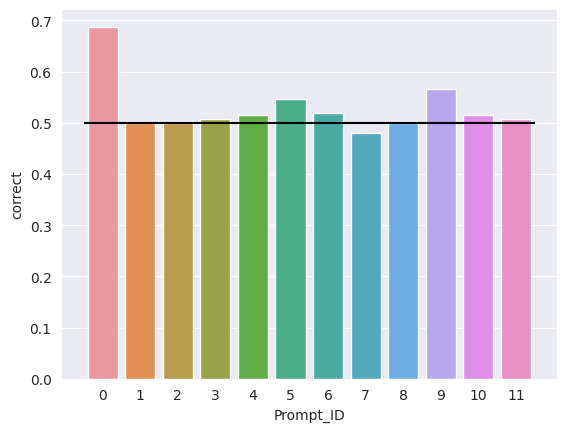

In [21]:
import seaborn as sns
sns.set_style("darkgrid")
ax = sns.barplot(data = ratio_by_prompt, x='Prompt_ID', y='correct')
ax.hlines(0.5, -0.5, 11.5, color='black')